In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from keras.models import load_model
import keras.backend as K

import cv2

from skimage.morphology import skeletonize

from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph

from patchify import patchify, unpatchify

from skimage import morphology

import networkx as nx

2024-01-17 20:34:39.627320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 20:34:39.627386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 20:34:39.629086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 20:34:39.636477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_images(path, type):

    file_list = os.listdir(path)
    images = []

    for filename in file_list:
        if filename.endswith(type):
            input_image_path = os.path.join(path, filename)
            input_image = cv2.imread(input_image_path, 0)
            images.append(input_image)
    
    return images

In [3]:
def roi_image(input_im):

    if len(input_im.shape) == 3 and input_im.shape[2] == 3:
        im_gray = cv2.cvtColor(input_im, cv2.COLOR_BGR2GRAY)
    elif len(input_im.shape) == 2:
        # If the input image is already grayscale, no need to convert
        im_gray = input_im
    else:
        # Handle other cases (e.g., images with more than 3 channels)
        raise ValueError("Unsupported number of channels in input image")

    kernel = np.ones((50, 50), dtype="uint8")

    im_e = cv2.dilate(im_gray, kernel, iterations=1)
    im_closing = cv2.erode(im_e, kernel, iterations=1)

    th, output_im = cv2.threshold(im_closing, 160, 255, cv2.THRESH_BINARY)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    area_of_interest = None
    largest_area = 0

    for i in range(1, len(stats)):
        x, y, w, h, area = stats[i]
        if area > largest_area:
            largest_area = area
            area_of_interest = (x, y, w, h)

    x, y, w, h = area_of_interest

    image = cv2.rectangle(input_im, (x, y), (x+w, y+h), (0, 0, 255), 2)

    roi = input_im[y:y+h, x:x+w]
    return roi, y, h, x, w

In [4]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        y_pred = tf.cast(y_pred>0.5, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [5]:
def padder(image, patch_size):

    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [6]:
def predict_all(images, patch_size):

    predictions = []

    for image in images:
    
        image, _, _, _, _ = roi_image(image)
        image = padder(image, patch_size)
        
        patches = patchify(image, (patch_size, patch_size), step=patch_size)
        
        i = patches.shape[0]
        j = patches.shape[1]
        
        patches = patches.reshape(-1, patch_size, patch_size, 1)
        
        preds = model.predict(patches/255)
        
        preds_reshaped = preds.reshape(i, j, patch_size, patch_size)
        
        predicted_mask = unpatchify(preds_reshaped, (i*patch_size, j*patch_size))

        predictions.append(predicted_mask)

    return predictions

In [7]:
def highlight_top_objects(image, prediction, num_objects=5):
    def sort_objects_by_area(stats):
        areas = [stat[-1] for stat in stats[1:]]
        sorted_areas = sorted(enumerate(areas, start=1), key=lambda x: x[1], reverse=True)
        return sorted_areas

    def extract_and_highlight_objects(image, prediction, sorted_areas, num_objects):
        plants = []
        plants_pred = []

        for i in range(1, num_objects + 1):
            index, area = sorted_areas[i - 1]
            x, y, w, h, _ = stats[index]

            cropped_roi_pred = prediction[y:y + h, x:x + w]
            cropped_roi = image[y:y + h, x:x + w]

            plants.append(cropped_roi)
            plants_pred.append(cropped_roi_pred)

            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
            prediction = cv2.rectangle(prediction, (x, y), (x + w, y + h), (0, 0, 255), 2)

        return image, prediction, plants, plants_pred

    pred = cv2.convertScaleAbs(prediction)

    _, _, stats, _ = cv2.connectedComponentsWithStats(pred)

    sorted_areas = sort_objects_by_area(stats)

    num_objects = min(num_objects, len(stats) - 1)

    result_image, result_pred, highlighted_plants, highlighted_plants_pred = extract_and_highlight_objects(
        image, prediction, sorted_areas, num_objects
    )

    return result_image, result_pred, highlighted_plants, highlighted_plants_pred

In [8]:
def find_end_node(graph):
 
    src = list(graph['node-id-src'])
    end_nodes = []
    for destination in list(graph['node-id-dst']):
        if destination not in src:
            end_nodes.append(destination)
    return end_nodes

In [9]:
def get_nodes(object):

    skeleton = skeletonize(object>0.3)
    summary = summarize(Skeleton(skeleton))
    end_nodes = find_end_node(summary)
    # summary = summary[(summary['node-id-dst'].isin(end_nodes)) | (summary['node-id-src'] == 0)]
    # summary = summary[summary['skeleton-id'] == 0]

    return summary

In [10]:
model = load_model('root_model.h5', custom_objects={'f1':f1, 'iou':iou})

2024-01-17 20:34:41.922214: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
images = load_images('task_6_images', '.tif')

In [12]:
patch_size = 256

In [13]:
roi_images = []

for image in images:
    new_im, _, _, _, _ = roi_image(image)
    new_im = padder(new_im, patch_size)
    roi_images.append(new_im)

In [14]:
predictions = predict_all(roi_images, patch_size)

4/4 [==============================] - 2s 418ms/step


In [1]:
index = 2
test_image = roi_images[index]
test_pred = predictions[index]

NameError: name 'roi_images' is not defined

In [ ]:
test_image, test_pred, plants, plants_pred = highlight_top_objects(test_image, test_pred)

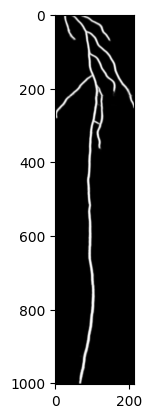

In [17]:
plt.imshow(plants_pred[0], cmap='gray')

In [18]:
data = []
checker = []

# Assuming get_nodes function is defined somewhere

for idx, plant_pred in enumerate(plants_pred):
    nodes = get_nodes(plant_pred)
    checker.append(nodes)
    G = nx.from_pandas_edgelist(nodes, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
    all_nodes = list(G.nodes())
    first_node = all_nodes[0]
    last_node = all_nodes[-1]
    path = nx.dijkstra_path(G, first_node, last_node, weight='branch-distance')
    print(path)
    primary_root = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')
    
    # Append the result to the list
    data.append({'Name': f'plant_{idx + 1}', 'Primary_Root': primary_root})

# Create DataFrame from the list
result_df = pd.concat([pd.DataFrame(data[i:i+1]) for i in range(len(data))], ignore_index=True)

[0, 173, 345, 532, 697, 1034, 1165]
[19, 38, 92, 121, 177, 395, 649, 834, 1113, 1567]
[2, 21, 100, 187, 386, 560, 992, 1310]
[0, 26, 122, 245, 337, 1134]
[0, 59, 131, 985]


In [19]:
result_df

,Name,Primary_Root
0,plant_1,410.592929
1,plant_2,1051.747258
2,plant_3,995.019336
3,plant_4,1064.575685
4,plant_5,943.592929
